# **Water Permamency**


In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import xarray as xr

import dask
from dask.distributed import Client

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


Import required DC utils

In [28]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon
from datacube.storage import masking
from datacube_utilities.clean_mask import lee_filter
from datacube_utilities.dc_utilities import write_geotiff_from_xr




Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 5 Cores: 15 Memory: 100.00 GB


Define aoi via wkt polygon (could be subbed or shapefile)

In [9]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#whole country
#aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
#VaturuDam
aoi_wkt = "POLYGON((177.6457816390133 -17.71173524964527,177.6754790572262 -17.71173524964527,177.6754790572262 -17.75342914493593,177.6457816390133 -17.75342914493593,177.6457816390133 -17.71173524964527))"

In [10]:
#set baseline start and end of period
start_date = '2019-1-1'
end_date = '2019-12-30'
res = (30)

output_projection = "EPSG:3460"
crs = "EPSG:3460"

In [11]:
dc = datacube.Datacube(app="water permamency")

In [12]:
dask_chunks=dict(
    time=1,
    x=1000,
    y=1000
)

In [13]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [14]:
#display_map(latitude = lat_extents, longitude = lon_extents)

In [15]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")

In [16]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [17]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [18]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [19]:
#create resolution
resolution = (-res, res)

In [20]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(start_date, end_date)

### Load Data

Generic query specs

In [21]:
query = dict(latitude = lat_range,
             longitude = lon_range,
             output_crs = output_projection,
             crs = crs,
             time = baseline_time_period,
             resolution = resolution,
             group_by = 'solar_day',
             dask_chunks = dask_chunks,   
            )


Dataset-specifics

In [22]:
dsL8 = dc.load(product='ls8_water_classification',
               measurements = ["water"],
               **query)
dsL8

,Array,Chunk
Bytes,1.47 MB,32.76 kB
Shape,"(45, 156, 105)","(1, 156, 105)"
Count,113 Tasks,45 Chunks
Type,int16,numpy.ndarray


In [23]:

def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [24]:
%%time
waterL8 = dsL8.where(dsL8 != -9999)

CPU times: user 26.7 ms, sys: 3.75 ms, total: 30.4 ms
Wall time: 57.1 ms


In [25]:
%%time
water_composite_mean = waterL8.water.mean(dim='time')

CPU times: user 16.9 ms, sys: 4.19 ms, total: 21.1 ms
Wall time: 20.3 ms


In [26]:
%%time
water_composite_mean = water_composite_mean.compute()

CPU times: user 311 ms, sys: 15.9 ms, total: 327 ms
Wall time: 16.1 s


Visualise wofs summary product

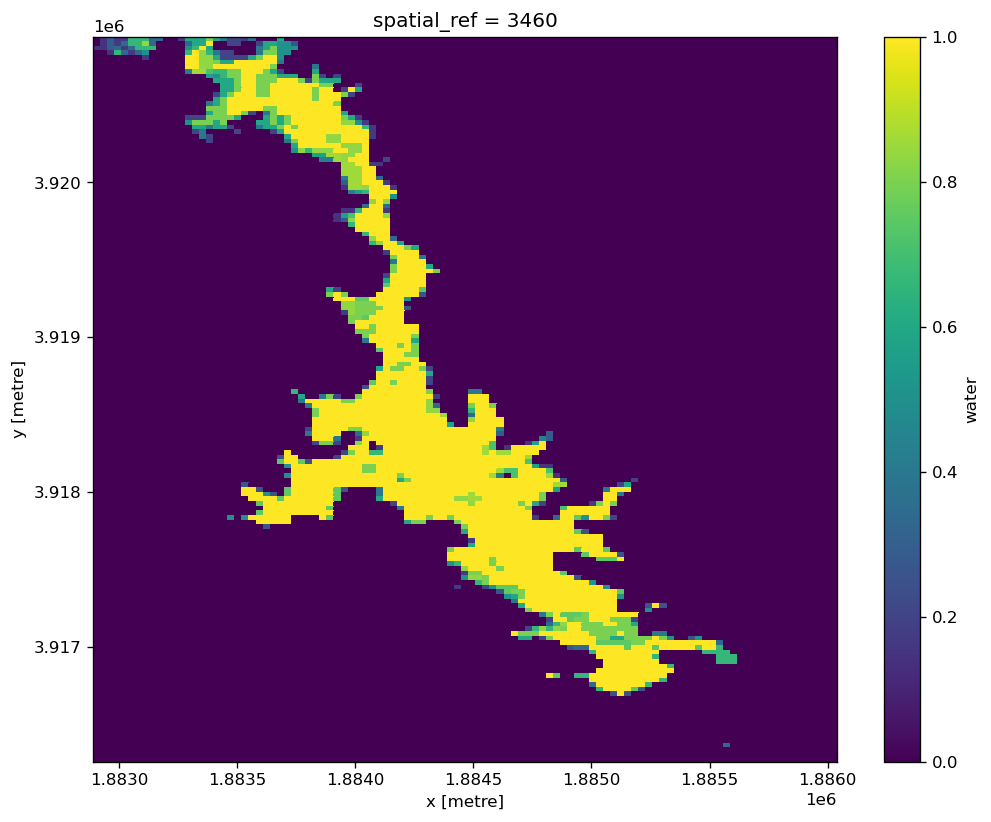

In [27]:
plt.figure(figsize = (10,8), dpi=120)
water_composite_mean.plot()

In [22]:
write_geotiff_from_xr('ls8_water.tiff', water_composite_mean, ["water"], crs=output_projection, x_coord = 'x', y_coord = 'y')

---